<a href="https://colab.research.google.com/github/Shivangi10-10/Big-Data/blob/main/Big_data_with_spark_and_hadoop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyspark
!pip install matplotlib seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 10.9 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840625 sha256=3889d55a0c3b74e8f4042fc80df61c125054385922fad7b50e59accd53df9581
  Stored in directory: /root/.cache/pip/wheels/1b/3a/92/28b93e2fbfdbb07509ca4d6f50c5e407f48dce4ddbda69a4ab
Successfully built pyspark
ERROR: Invalid requirement: 'matplotlib\xa0seaborn': Expected end or semicolon (after name and no valid version specifier)
    matplotlib seaborn
              ^


Saving st_scores.csv to st_scores.csv
+-------+---------+----------+---------+
|Student|  Subject|ClassScore|TestScore|
+-------+---------+----------+---------+
|  James|     Math|        95|   65.175|
|  James|Chemistry|        50|    32.45|
|  James|  Physics|        48|   37.675|
|  James|  Biology|        75|   76.725|
|   Lora|     Math|        45|   49.225|
+-------+---------+----------+---------+
only showing top 5 rows



<ipython-input-2-de9d15af2455>:59: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="Subject", y="TotScore", hue="IsOutlier", style="IsOutlier", data=pandas_outliers, palette="cool", s=100)


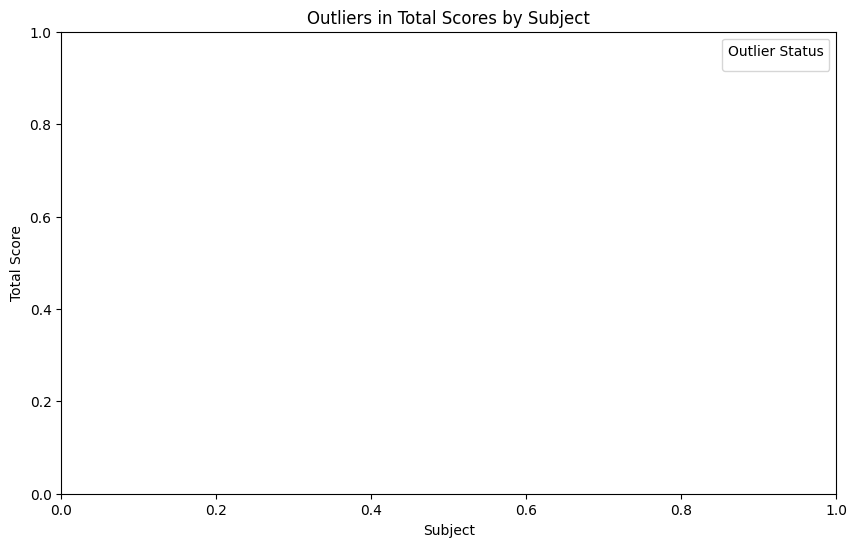

<ipython-input-2-de9d15af2455>:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Subject", y="ConsistencyScore", data=pandas_consistency_score, palette="viridis")


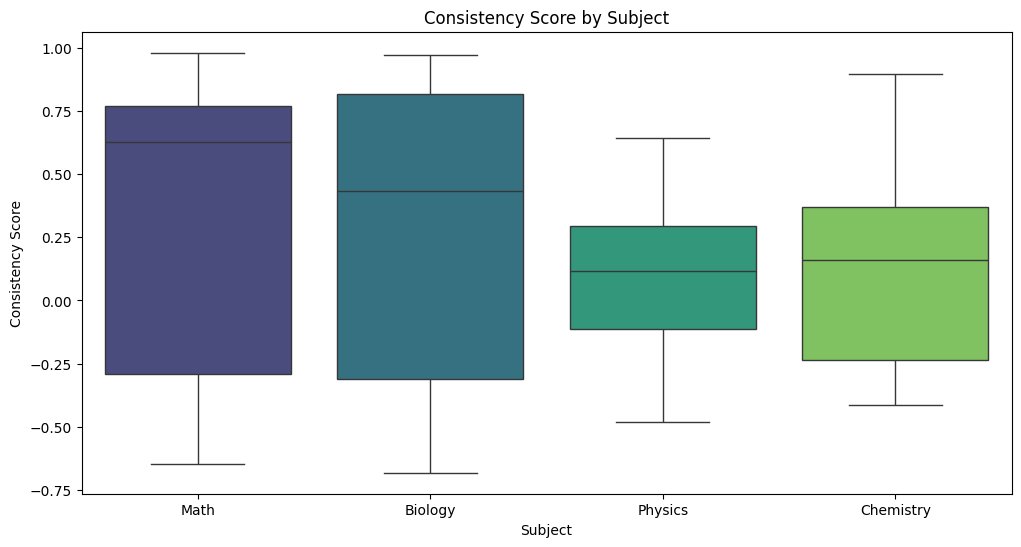

Study Focus Area Recommendations:
    Student    Subject   TotScore     Recommendation
1      Lora       Math   94.22500  Needs Improvement
2      Leny       Math  101.17500  Needs Improvement
4     Elvis       Math   60.00000  Needs Improvement
6    Daniel       Math   86.39375  Needs Improvement
7      Dave       Math   90.80625  Needs Improvement
8      Roby       Math   99.13750  Needs Improvement
9    Pamela       Math   54.75000  Needs Improvement
13     Lisa    Biology   81.07500  Needs Improvement
16   Daniel    Biology  111.34375  Needs Improvement
18     Roby    Biology   74.38125  Needs Improvement
19   Pamela    Biology  103.66875  Needs Improvement
20    James    Physics   85.67500  Needs Improvement
21     Lora    Physics  108.80000  Needs Improvement
23     Lisa    Physics  106.35000  Needs Improvement
25  Micheal    Physics   79.68125  Needs Improvement
26   Daniel    Physics   96.90000  Needs Improvement
28     Roby    Physics   96.11250  Needs Improvement
30    James 

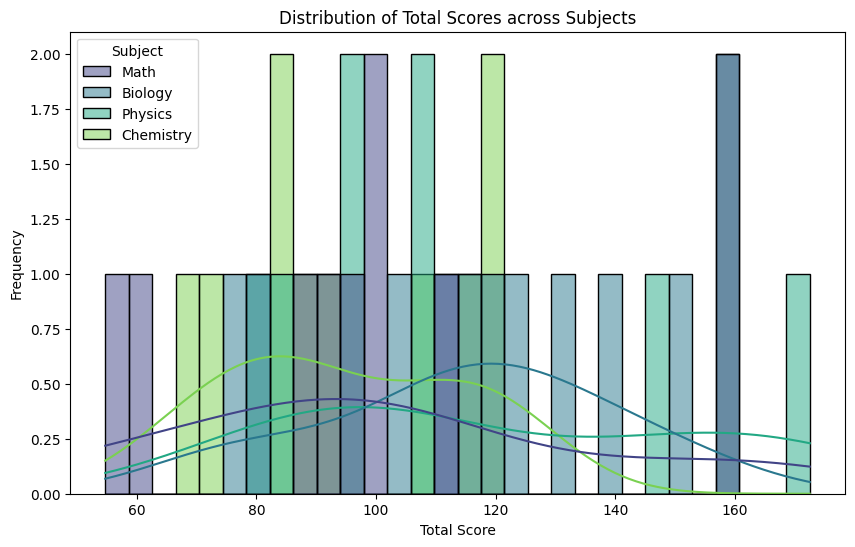

<ipython-input-2-de9d15af2455>:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Student", y="AvgScore", data=pandas_avgscore, palette="coolwarm")


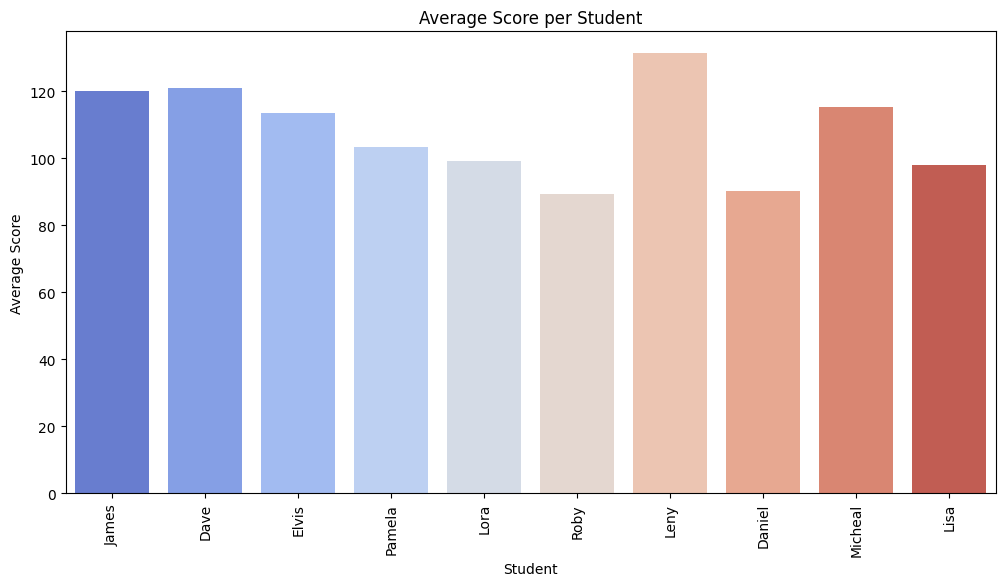

<ipython-input-2-de9d15af2455>:118: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Subject", y="TopScore", data=pandas_top_scores, palette="rocket")


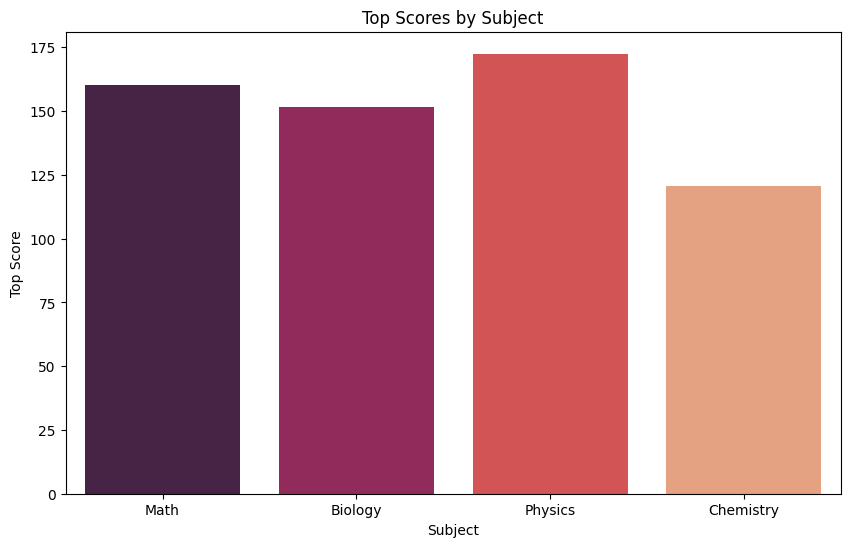

Data processing, analytics, and visualization completed successfully!


In [2]:
# Import required libraries
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, max, avg, count, stddev, date_format, expr, when
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Initialize Spark session
spark = SparkSession.builder.appName("AdvancedBigDataProject").getOrCreate()

# Function to load CSV file
def load_csv():
    from google.colab import files
    uploaded = files.upload()
    file_name = list(uploaded.keys())[0]
    df = spark.read.format("csv").option("inferSchema", "true").option("header", "true").load(file_name)
    return df.withColumnRenamed("Class Score", "ClassScore").withColumnRenamed("Test Score", "TestScore")

# Load and display data
raw_stdata = load_csv()
raw_stdata.show(5)

# Define output path for partitioned data in Colab environment
fileout = "/content/partitioned_st"
raw_stdata.write.format("parquet").mode("overwrite").option("compression", "gzip").partitionBy("Subject").save(fileout)

# Load partitioned data and process
st_data = spark.read.parquet(fileout)
tot_score = st_data.withColumn("TotScore", col("ClassScore") + col("TestScore"))
tot_score.cache()

# Feature 1: Monthly Performance Tracking (if temporal data available)
# Adding Month column based on Date and aggregating monthly performance
if "Date" in tot_score.columns:
    monthly_performance = tot_score.withColumn("Month", date_format(col("Date"), "yyyy-MM")) \
                                   .groupBy("Month", "Subject").agg(avg("TotScore").alias("MonthlyAvgScore"))
    pandas_monthly_performance = monthly_performance.toPandas()

    # Plotting Monthly Performance Trend
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=pandas_monthly_performance, x="Month", y="MonthlyAvgScore", hue="Subject", marker="o")
    plt.title("Monthly Performance Trend by Subject")
    plt.xlabel("Month")
    plt.ylabel("Average Total Score")
    plt.xticks(rotation=45)
    plt.show()

# Feature 2: Outlier Detection for Total Scores
# Using standard deviation to detect outliers in Total Scores
stats = tot_score.groupBy("Subject").agg(avg("TotScore").alias("AvgScore"), stddev("TotScore").alias("StdDev"))
tot_score_with_outliers = tot_score.join(stats, "Subject") \
                                   .withColumn("IsOutlier", when((col("TotScore") > col("AvgScore") + 2*col("StdDev")) |
                                                                 (col("TotScore") < col("AvgScore") - 2*col("StdDev")), "Yes").otherwise("No"))
pandas_outliers = tot_score_with_outliers.filter(col("IsOutlier") == "Yes").toPandas()

# Plotting Outliers
plt.figure(figsize=(10, 6))
sns.scatterplot(x="Subject", y="TotScore", hue="IsOutlier", style="IsOutlier", data=pandas_outliers, palette="cool", s=100)
plt.title("Outliers in Total Scores by Subject")
plt.xlabel("Subject")
plt.ylabel("Total Score")
plt.legend(title="Outlier Status")
plt.show()

# Feature 3: Custom Performance Metric - Consistency Score
# Calculating a Consistency Score based on the deviation from average score in each subject
consistency_score = tot_score.join(stats, "Subject") \
                             .withColumn("ConsistencyScore", expr("1 - abs(TotScore - AvgScore) / StdDev")) \
                             .select("Student", "Subject", "TotScore", "ConsistencyScore")
pandas_consistency_score = consistency_score.toPandas()

# Plotting Consistency Score per Subject
plt.figure(figsize=(12, 6))
sns.boxplot(x="Subject", y="ConsistencyScore", data=pandas_consistency_score, palette="viridis")
plt.title("Consistency Score by Subject")
plt.xlabel("Subject")
plt.ylabel("Consistency Score")
plt.show()

# Feature 4: Recommendation System for Study Focus Areas
# Identifying weak areas for each student by highlighting subjects with below-average scores
recommendations = tot_score.join(stats, "Subject") \
                           .withColumn("Recommendation", when(col("TotScore") < col("AvgScore"), "Needs Improvement").otherwise("Good Performance")) \
                           .select("Student", "Subject", "TotScore", "Recommendation")
pandas_recommendations = recommendations.toPandas()

# Display recommendations for students needing improvement
print("Study Focus Area Recommendations:")
print(pandas_recommendations[pandas_recommendations["Recommendation"] == "Needs Improvement"])

# Convert Spark DataFrames to Pandas for initial visualizations
pandas_tot_score = tot_score.toPandas()
pandas_avgscore = tot_score.groupBy("Student").agg(avg("TotScore").alias("AvgScore")).toPandas()
pandas_top_scores = tot_score.groupBy("Subject").agg(max("TotScore").alias("TopScore")).toPandas()

# Visualizations

# Plot 1: Distribution of Total Scores across Subjects
plt.figure(figsize=(10, 6))
sns.histplot(pandas_tot_score, x="TotScore", hue="Subject", kde=True, palette="viridis", bins=30)
plt.title("Distribution of Total Scores across Subjects")
plt.xlabel("Total Score")
plt.ylabel("Frequency")
plt.show()

# Plot 2: Average Score per Student
plt.figure(figsize=(12, 6))
sns.barplot(x="Student", y="AvgScore", data=pandas_avgscore, palette="coolwarm")
plt.title("Average Score per Student")
plt.xlabel("Student")
plt.ylabel("Average Score")
plt.xticks(rotation=90)
plt.show()

# Plot 3: Top Scores by Subject
plt.figure(figsize=(10, 6))
sns.barplot(x="Subject", y="TopScore", data=pandas_top_scores, palette="rocket")
plt.title("Top Scores by Subject")
plt.xlabel("Subject")
plt.ylabel("Top Score")
plt.show()

# Stop Spark session
spark.stop()

print("Data processing, analytics, and visualization completed successfully!")
